### 1. Загрузка данных

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopy.distance

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import category_encoders as ce 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > kaggle_requirements.txt
#!pip freeze > local_venv_requirements.txt

In [11]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
#df_train = pd.read_csv('hotels_train.csv')
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
#df_test = pd.read_csv('hotels_test.csv')
sample_submission = pd.read_csv('submission.csv') # самбмишн
#sample_submission = pd.read_csv('submission.csv')

In [12]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], sort=False, ignore_index=True)#.reset_index(drop=True) # объединяем

In [13]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [15]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


array([[<Axes: title={'center': 'additional_number_of_scoring'}>,
        <Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>,
        <Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>],
       [<Axes: title={'center': 'reviewer_score'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lng'}>],
       [<Axes: title={'center': 'sample'}>, <Axes: >, <Axes: >]],
      dtype=object)

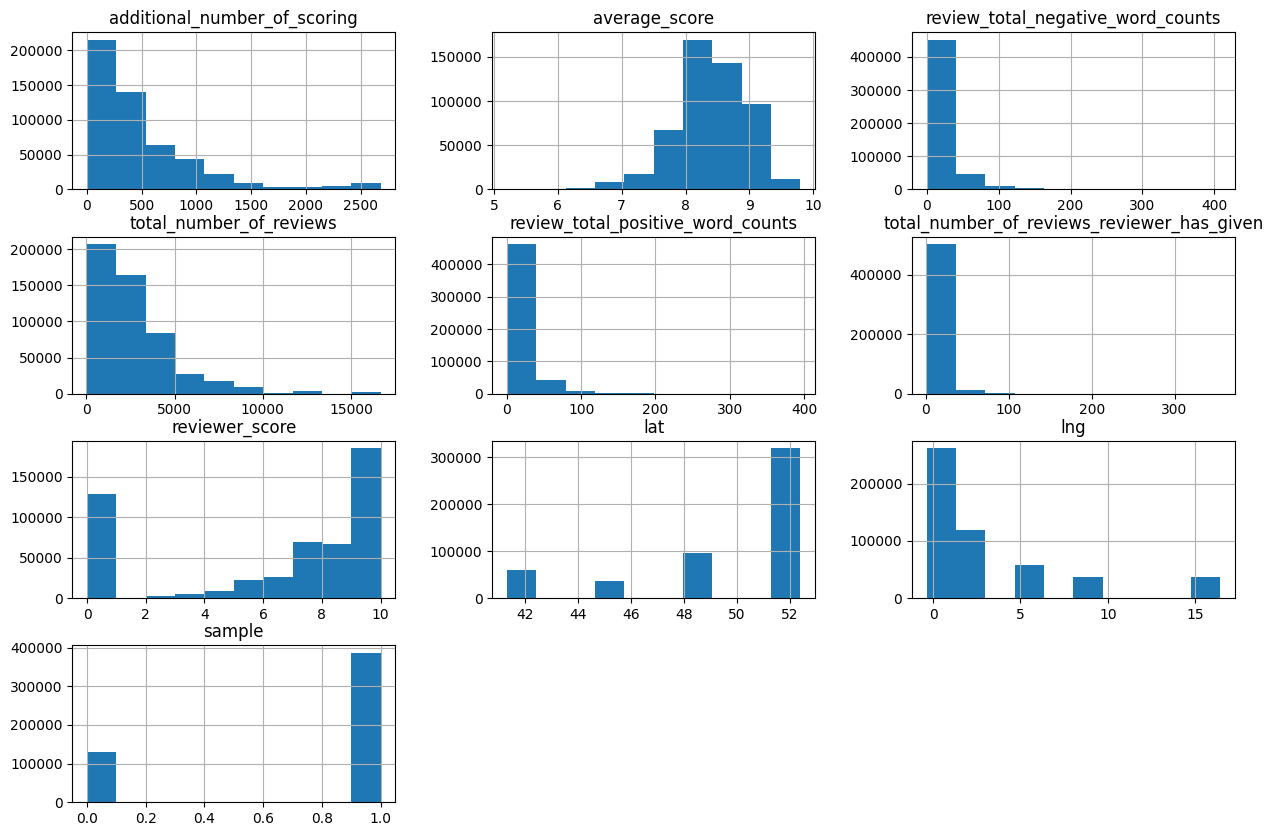

In [16]:
data.hist(figsize=(15,10))

### 2. Очистка данных

#### 2.1. Очистка от дубликатов

In [17]:
data.duplicated().sum()

336

Дубликатов в датасете 336, но мы не можем их удалить т.к. тест не будет совпадать с сабмитом.

In [18]:
# # удаляем дубликаты из тренировочного датасета, проверяем результат
# df_train.drop_duplicates(inplace=True)
# df_train.duplicated().sum()

# # заново собираем датасет для дальнешей работы
# df_train['sample'] = 1
# df_test['sample'] = 0
# df_test['reviewer_score'] = 0

# data = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

#### 2.2. Очистка от пропусков

In [19]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
dtype: int64

Заполняем пропуски нулями

In [20]:
data['lat'] = data['lat'].fillna(0) 
data['lng'] = data['lng'].fillna(0)

### 3. Разведывательный анализ данных

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

``Посмотрим на корреляцию``

<Axes: >

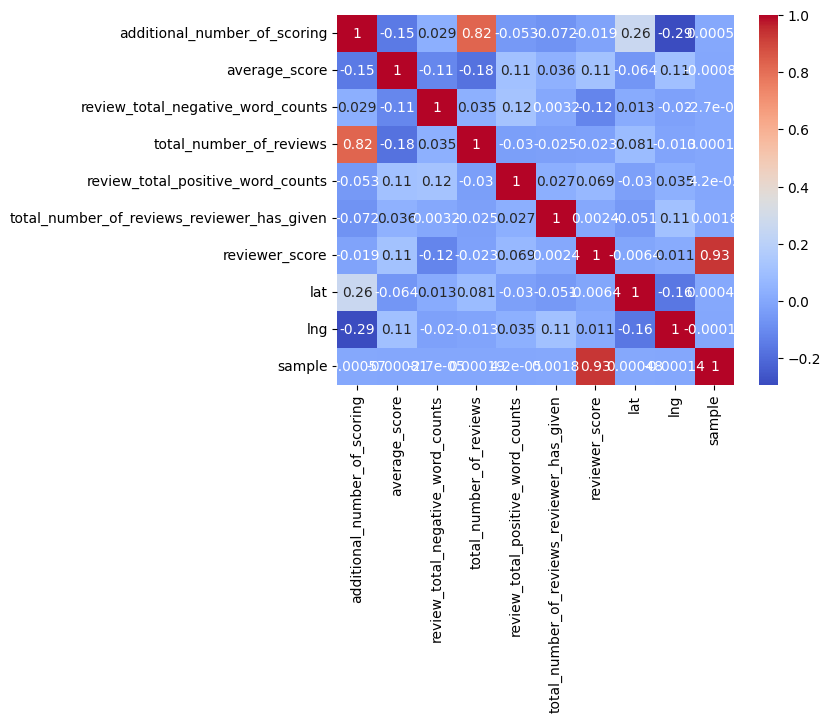

In [22]:
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap= 'coolwarm')

Наблюдается сильная корреляция между признаками total_number_of_reviews и additional_number_of_scoring. ``Удалим признак additional_number_of_scoring``.

In [23]:
data = data.drop('additional_number_of_scoring', axis=1)

#### 3.1. План действий по каждому из нечисловых признаков

- hotel_address: извлечь 2 признака - страну (для обучения модели) и город (для дальнейшего вычисления расстояния от центра)
- review_date: создать новый признак сезонности
- hotel_name: сам по себе признак бесполезен, удаляем (можно выделить сетевые отели, но это очень объемная работа)
- reviewer_nationality: скорее всего полезный признак, приведем к необходимому для кодирования виду
- negative_review: измеряем эмоциональную оценку
- positive_review: измеряем эмоциональную оценку
- tags: анализируем теги, создаем несколько новых признаков
- days_since_review: переводим в число (дней)
- lat и lng: создаем признак "расстояние до центра города"

#### 3.2. Проектирование новых признаков

#### hotel_address

Выделим из данного признака два параметра- страна и город. Из параметра город мы создадим новый признак - расстояние до центра.

In [24]:
# создаем новые признаки - город и страна
data['country'] = data.hotel_address.apply(lambda x: 'United Kingdom' if 'United' in x.split()[-2] else x.split()[-1])
data['city'] = data.hotel_address.apply(lambda x: 'London' if 'United' in x.split()[-2] else x.split()[-2])

# удаляем исходный признак
data.drop('hotel_address', axis=1, inplace=True)

In [25]:
data['country'].value_counts()

country
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: count, dtype: int64

In [26]:
data['city'].value_counts()

city
London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: count, dtype: int64

#### review_date

В среднем по Европе сезонность по месяцам года следующая - high (июнь-август), low (декабрь-февраль) и shoulder (март-май, сентябрь-ноябрь).

In [27]:
# создаем новый признак сезонности проживания
data.review_date = pd.to_datetime(data.review_date, format="%m/%d/%Y")
data['season'] = data.review_date.apply(lambda x: 'high' if 6<=x.month<=8 else 'low' if x.month==12 or 1<=x.month<=2 else 'shoulder')

# удаляем исходный признак
data.drop('review_date', axis=1, inplace=True)

#### hotel_name

Удаляем этот признак

In [28]:
# удаляем исходный признак
data.drop('hotel_name', axis=1, inplace=True)

#### reviewer_nationality

Приведем к необходимому для кодирования виду - удалим лишне пробелы и оставим ТОП-50, а остальные пометим как "другие"

In [29]:
# удаляем пробелы в ячейках
data.reviewer_nationality = data.reviewer_nationality.apply(lambda x: x.strip())

# создаем список ТОП-50
reviewer_top_50 = data.reviewer_nationality.value_counts().nlargest(50)

#корреткируем изначальный признак
data.reviewer_nationality = data.reviewer_nationality.apply(lambda x: x if x in reviewer_top_50 else 'other')

#### negative_review и positive_review
Измеряем эмоциональную оценку при помощи SentimentIntensityAnalyzer и создать на ее основе один признак по параметру 'compound'

In [30]:
#!pip install nltk

In [31]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# 'подгружаем' инструмент оценки
sia = SentimentIntensityAnalyzer()

# создаем новый признак с эмоциональной оценкой отзыва на основе параметра оценки 'compound'
data['negative_sia_score'] = data.negative_review.apply(lambda x: sia.polarity_scores(x)['compound'])

# удаляем исходный признак
data.drop('negative_review', axis=1, inplace=True)


Аналогично поступаем с положительными отзывами

In [32]:
# создаем новый признак с эмоциональной оценкой отзыва на основе параметра оценки 'compound'
data['positive_sia_score'] = data.positive_review.apply(lambda x: sia.polarity_scores(x)['compound'])

# удаляем исходный признак
data.drop('positive_review', axis=1, inplace=True)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   reviewer_nationality                        515738 non-null  object 
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   tags                                        515738 non-null  object 
 8   days_since_review                           515738 non-null  object 
 9   lat                                         515738 non-null  float64
 

#### tags
Берем наиболее часто встречающиеся и выделяем по типу тэгов 3 дополнительных признака:

- trip_typе - может быть leisure или business, если нет этих тэгов ставим NaN
- mobile_submitt - тэг либо есть, либо его нет (1 или 0)
- guests - разделим на solo, couple, group и with children

In [34]:
# преобразуем строки с тэгами в списки для дальнейшего анализа и создания новых признаков
data.tags = data.tags.apply(lambda x: x[3:-3].split(" ', ' "))

# посмотрим сколько уникальных тэгов и как часто они встречаются
tags_list = []
for li in data.tags:
    for el in li:
        tags_list.append(el)
        
tags_list = pd.Series(tags_list)
tags_list.value_counts().nlargest(30)

Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Deluxe Double Room                 24823
Double or Twin Room                22393
Stayed 5 nights                    20845
Standard Double or Twin Room       17483
Classic Double Room                16989
Superior Double or Twin Room       13570
2 rooms                            12393
Stayed 6 nights                     9776
Standard Twin Room                  9745
Single Room     

In [35]:
# создаем три новых признака на основе наличия того или иного тэга в записи
data['trip_type'] = data.tags.apply(lambda x: 'leisure' if 'Leisure trip' in x else 'business' if 'Business trip' in x else np.NaN)

data['mobile_submitt'] = data.tags.apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

data['guest_type'] = data.tags.apply(lambda x: 'solo' if 'Solo traveler' in x else 'couple' if 'Couple' in x else 'group' if 'Group' in x 
                                    else 'with children' if 'Family with older children' in x or 'Family with young children' in x else np.NaN)

# удаляем изначальный признак с тэгами
data.drop('tags', axis=1, inplace=True)

#### days_since_review
вытягиваем из изначального столбца число дней.

In [36]:
# создаем новый столбец review_days и записываем туда число дней из признака
data['review_days'] = data.days_since_review.apply(lambda x: int(x.split()[0]))

# удаляем исходный признак
data.drop('days_since_review', axis=1, inplace=True)

#### lat и lng
Используем для вычисления расстояния отеля до центра города, получим координаты центра каждого города и вычислим для каждого отеля расстояние от него.

In [37]:
#запишем координаты центров городов в переменную
city_centre = data.city.value_counts().to_frame()

city_centre.insert(0, 'lat_centre', [
        51.508530,
        41.388790,
        48.853410,
        52.374030,
        48.208490,
        45.464270
])

city_centre.insert(1, 'lng_centre', [
        -0.125740,
        2.158990,
        2.348800,
        4.889690,
        16.372080,
        9.189510,
])

In [38]:
!pip install geopy

In [39]:
# при помощи функции и инсрумента geopy создаем и заполняем новый признак - расстояние до центра города
def dist_calc(city, lng, lat):
    lng_centre = city_centre['lng_centre'][city]
    lat_centre = city_centre['lat_centre'][city]
    return geopy.distance.geodesic([lng_centre, lat_centre], [lng, lat]).km

data['distance_to_centre'] = data.apply(lambda x: dist_calc(x.city, x.lng, x.lat), axis=1)

# удаляем исходные признаки координат и город
data.drop(['city', 'lat', 'lng'], axis=1, inplace=True)

### 3.3 Преобразование признаков

In [40]:
# признак национальности автора отзыва
bin_enc = ce.BinaryEncoder(cols=['reviewer_nationality'])
data_bin = bin_enc.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, data_bin], axis=1)

# признак страны отеля
ohe_enc = ce.OneHotEncoder(cols=['country'])
data_ohe = ohe_enc.fit_transform(data['country'])
data = pd.concat([data, data_ohe], axis=1)

# признак сезонности
ohe_enc = ce.OneHotEncoder(cols=['season'])
data_ohe = ohe_enc.fit_transform(data['season'])
data = pd.concat([data, data_ohe], axis=1)

# признак типа поездки
ohe_enc = ce.OneHotEncoder(cols=['trip_type'])
data_ohe = ohe_enc.fit_transform(data['trip_type'])
data = pd.concat([data, data_ohe], axis=1)

# признак типа гостей
ohe_enc = ce.OneHotEncoder(cols=['guest_type'])
data_ohe = ohe_enc.fit_transform(data['guest_type'])
data = pd.concat([data, data_ohe], axis=1)

# удаляем исходные признаки
data.drop(['reviewer_nationality', 'country', 'season', 'trip_type', 'guest_type'], axis=1, inplace=True)

### 3.4. Отбор признаков (мультиколлениарность)

<Axes: >

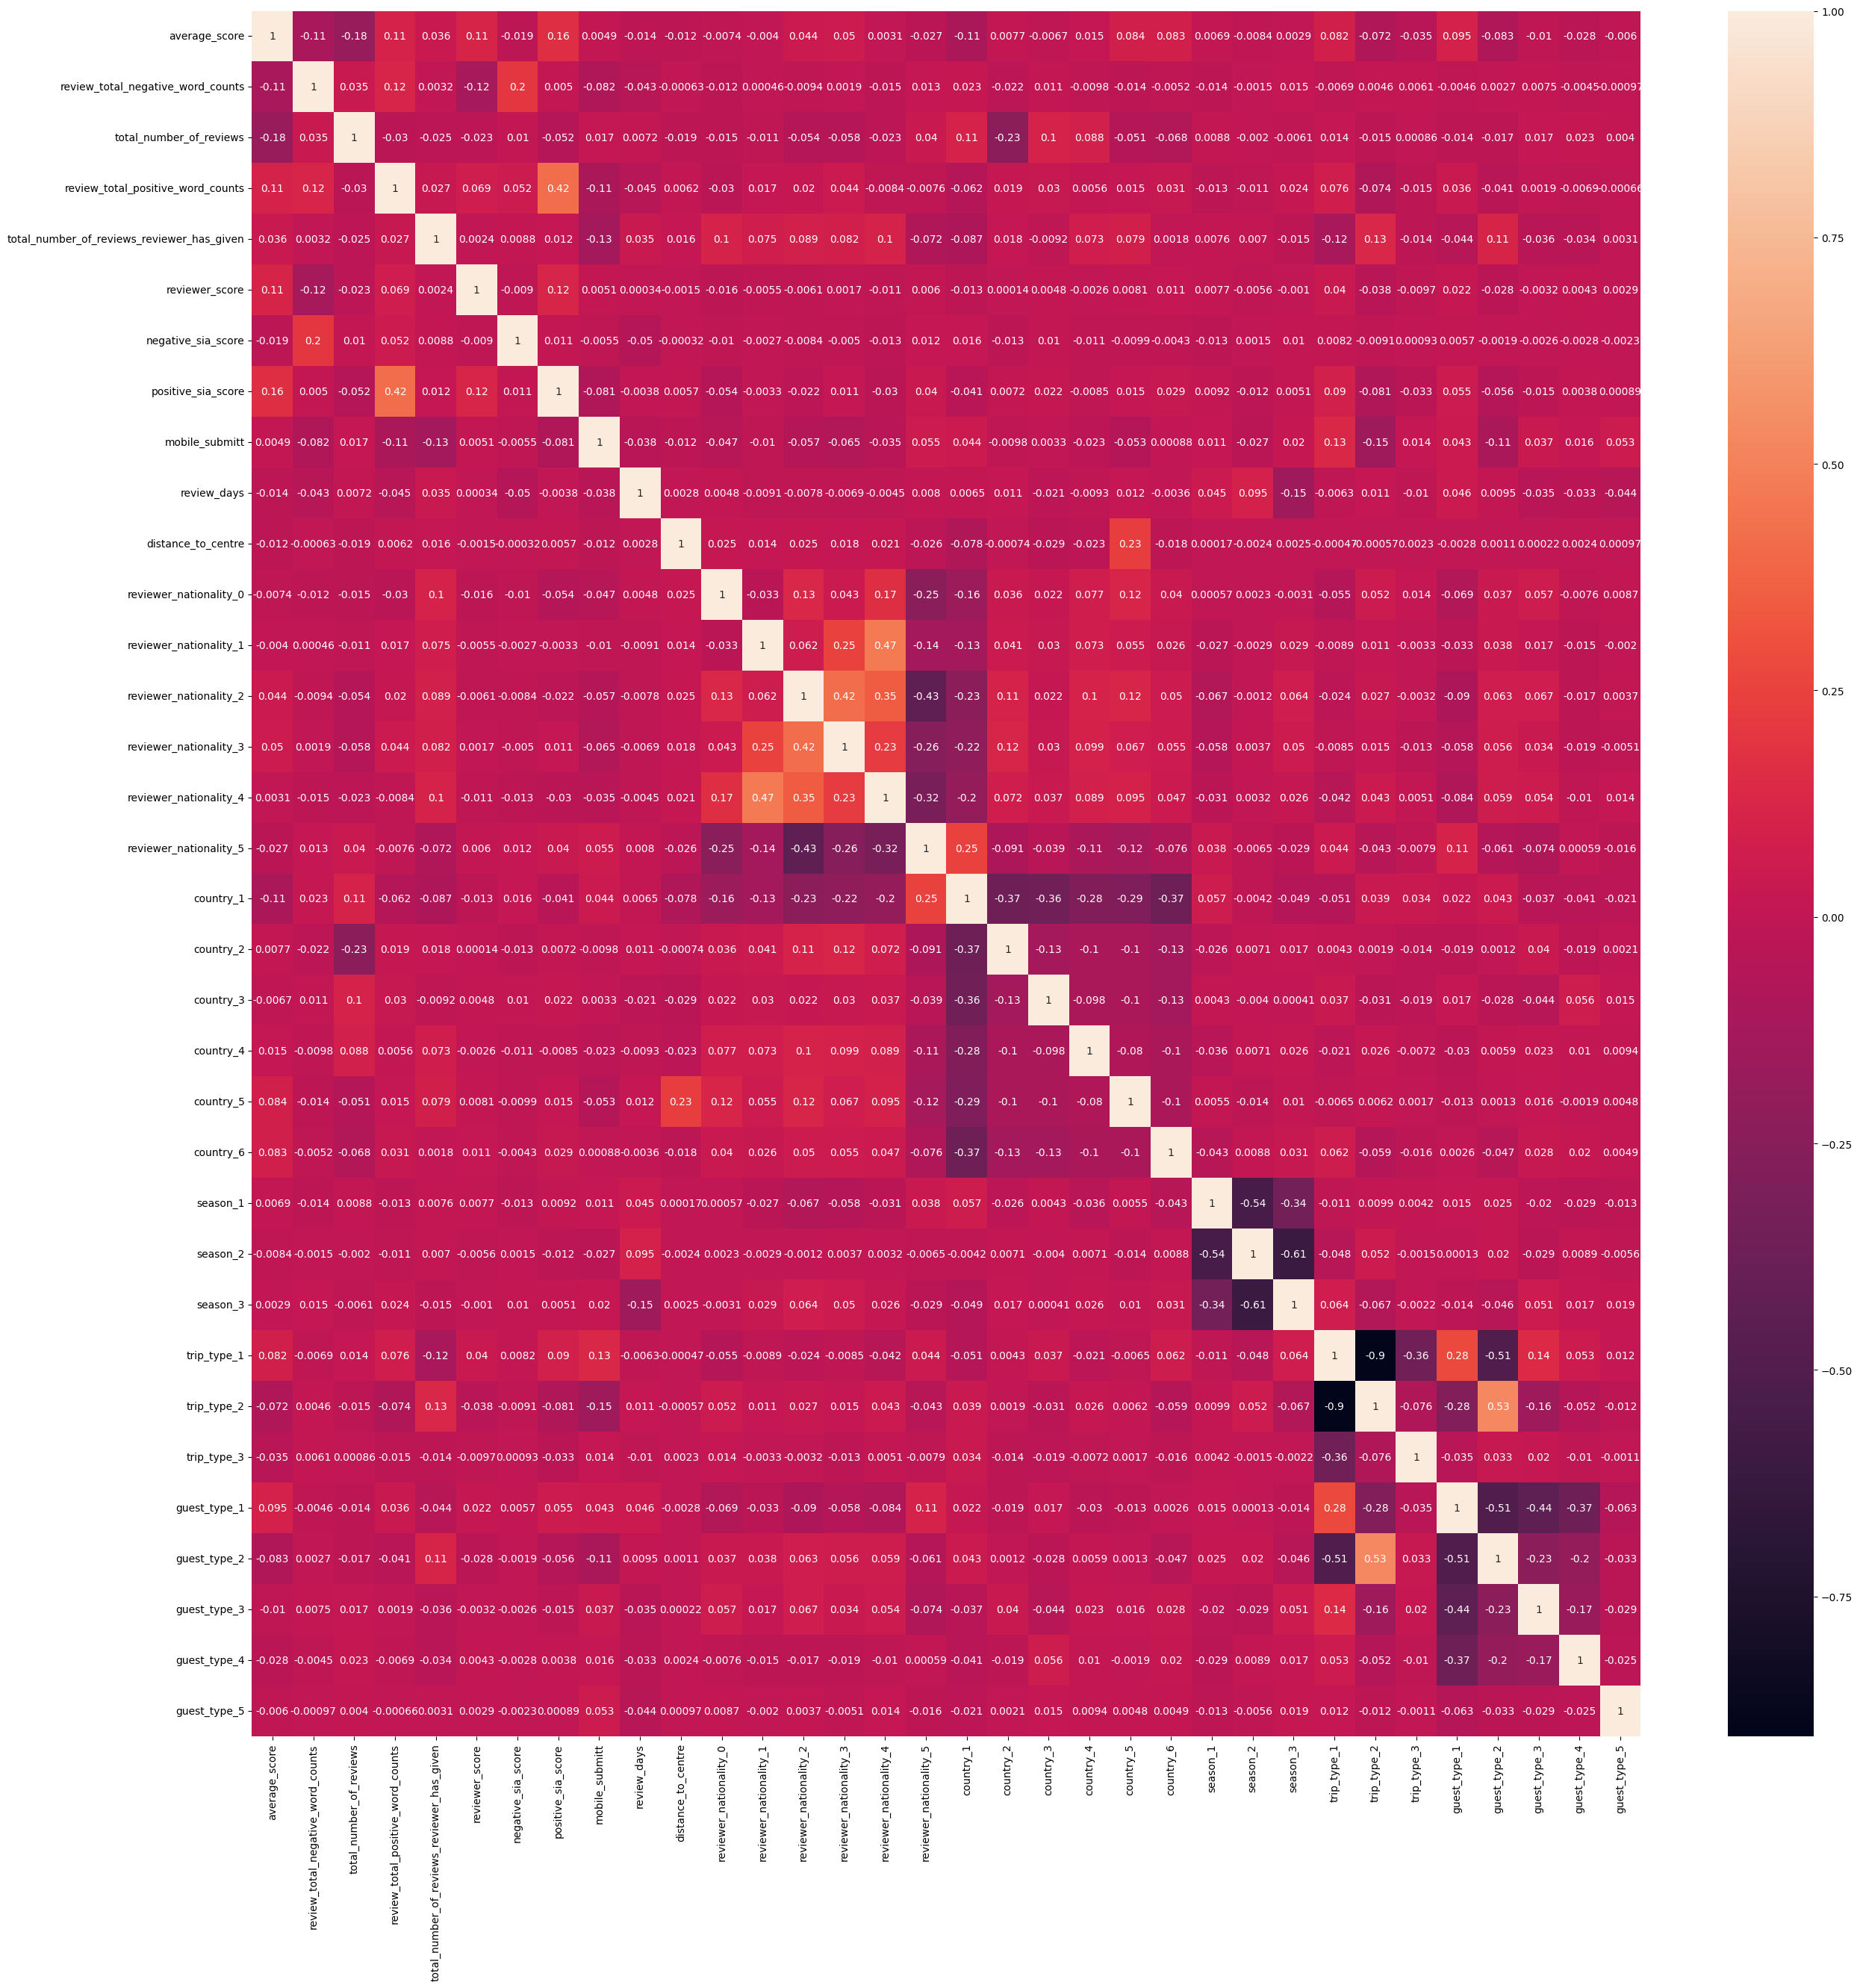

In [41]:
# тепловая карта корреляции признаков
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

### 4. Моделирование

#### 4.1. Подготовка данных

In [42]:
# разделим обратно датасет на тренировочный и тестовый
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # таргет
X = train_data.drop(['reviewer_score'], axis=1)

# выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### 4.2. Обучение модели и предсказание, оценка MAPE

In [43]:
# создаем модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказываем рейтинг в тестовов датасете и записываем в переменную y_pred
y_pred = model.predict(X_test)

# сравниваем предсказанные значения с реальными, метрика - MAPE
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


MAPE: 0.12559075181598942


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


<Axes: >

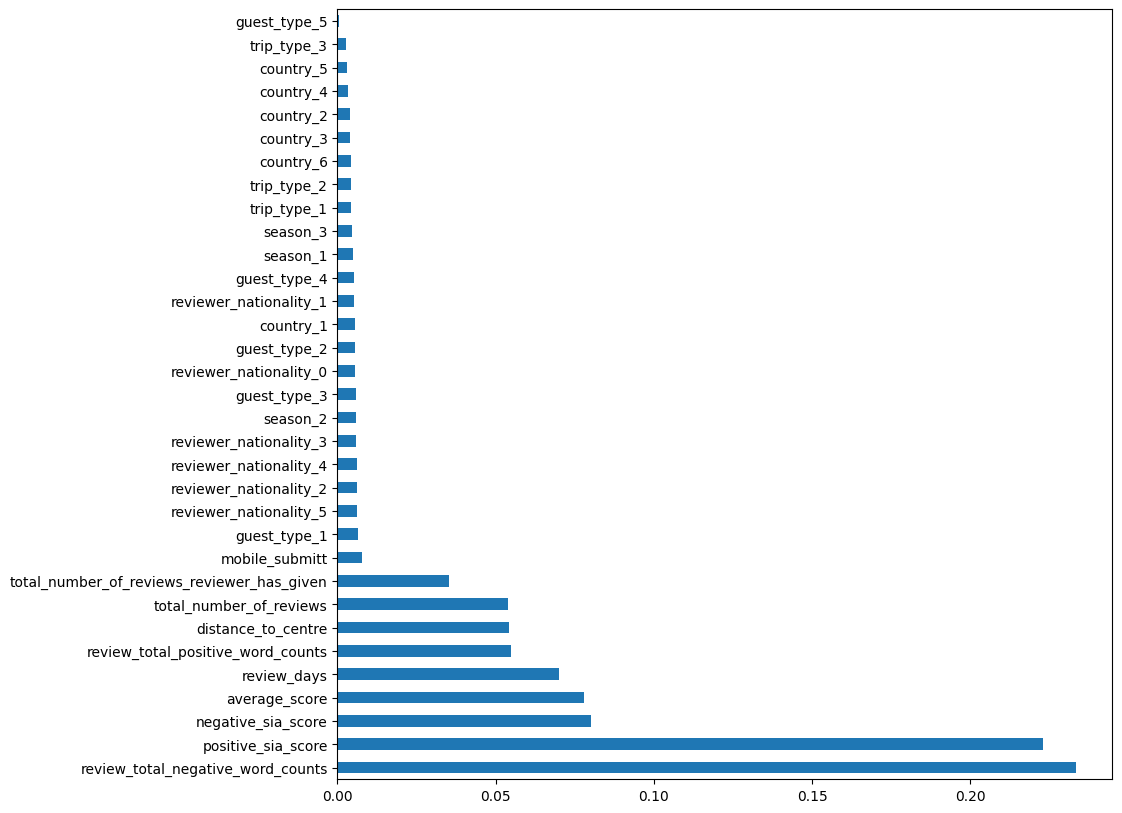

In [44]:
# оцениваем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

### 4.3. Прогноз тестовых данных, запись submission для Kaggle

In [45]:
test_data = test_data.drop(['reviewer_score'], axis=1)
sample_submission['reviewer_score'] = model.predict(test_data)
sample_submission.to_csv('submission.csv', index=False)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished


In [46]:
!pip freeze > requirements.txt

In [47]:
!pip list --format=freeze > requirements.txt